In [50]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import dataframe_image as dfi

import gensim #the library for Topic modelling

from gensim.models.ldamulticore import LdaMulticore

from gensim import corpora, models

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer


import warnings ###### /\
warnings.simplefilter('ignore') ###### /\
from itertools import chain ###### /\

In [51]:
#Open a user file

user_file = "C:\\Users\\zachi\\Desktop\\final_project_22\\data_nov_21.xlsx"
df=pd.read_excel(user_file)

In [52]:
#Remove unnecessary column - "removed 1"

df.drop(columns=['Removed 1'],inplace=True)

#Make the Category column easier to understand 

df=df.replace({'Category' : { 'Y' : "Antisemitic", 'W' : "Non-Antisemitic", 'U' : "Anti-Zionist" }})



#Convert "time stamp" to english

df = df.rename(columns={"חותמת זמן":"Time stamp"})

#Change the date time to the d/m/y

from datetime import datetime
df['Time stamp'] = pd.to_datetime(df['Time stamp'], errors='coerce') #This function convert the date text into dt.date type


#Fix the Summary column's text

df = df.replace(r'\n',' ', regex=True) 

posts_description = df["A short summary of the content- write briefly in your own words "]


#get rid of NaNs in category

list = ["Anti-Zionist",
"Antisemitic",
"Non-Antisemitic"]

df = df.loc[df['Category'] .isin(list)]
#This line is keeping rows which have one of the categories



Analyze content type by date range & platform

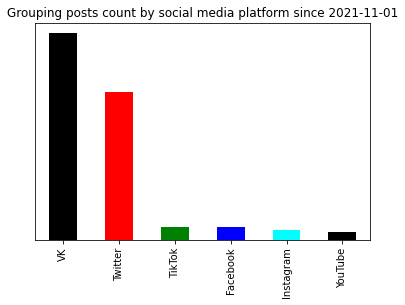

In [53]:
# ###### /\ convert textual user input into dat recognition

user_input = "2021-11-01"
the_user_target_date = df["Time stamp"]>user_input
new_df = df[the_user_target_date]

# Count posts for each platform in the data set

posts_in_platforms = new_df["Platform"].value_counts().plot(kind="bar",color=['black', 'red', 'green', 'blue', 'cyan'],title = "Grouping posts count by social media platform since" + " " + user_input)

posts_in_platforms.get_yaxis().set_visible(False)
###### /\ build a function if possible

plt.savefig("posts_in_platforms.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


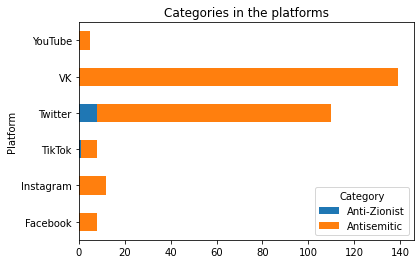

In [94]:
#Mapping the category type through the platforms

df_group_=df.groupby(['Category', 'Platform'])['Platform'].count().unstack('Category').fillna(0).astype(int)
categories_per_each_platform = df_group_.plot(kind='barh', stacked=True,mark_right = True ,title = "Categories in the platforms")

#categories_per_each_platform.get_yaxis().set_visible(False)

plt.savefig("categories_per_each_platform.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

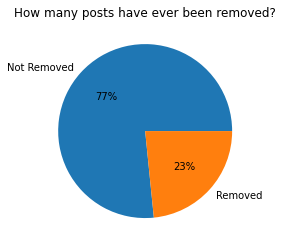

In [55]:
#Cheking the percentage of posts removing in general view

status = df["Removed"]

#df.groupby("Category").agg({status:"mean"})

# category = df["Category"] ###### /\


general_removal_view = status.value_counts() #get general info about the removal process of platforms

general_removal_view_plot = general_removal_view.plot(kind = "pie" , autopct='%1.0f%%', title = "How many posts have ever been removed?", textprops={'color':"black"}) 

general_removal_view_plot.get_yaxis().set_visible(False)

plt.savefig("general_removal_view_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

Content removal data (by category)

In [56]:
df.groupby(['Category', 'Removed'])['Removed'].count().unstack('Removed').fillna(0).astype(int)

#This function is grouping the DF by the removal status & the category
outpot_category_removal_stats= df.groupby(['Removed', 'Category'])['Category'].count().unstack('Category').fillna(0).astype(int).reindex(index = ['Removed','Not Removed']).astype("int")

In [57]:
#Saving the counting chart as a picture

dfi.export(outpot_category_removal_stats,"outpot_category_removal_stats_plot.png")


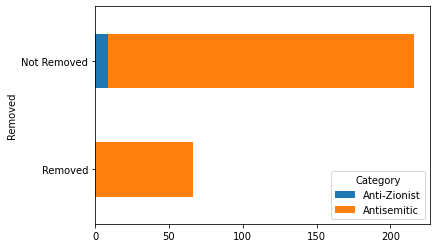

In [92]:
outpot_category_removal_stats_plot = outpot_category_removal_stats.plot(kind='barh', stacked=True,mark_right = True )


#outpot_category_removal_stats_plot.get_yaxis().set_visible(False)

plt.savefig("outpot_category_removal_stats_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


Content removal data (by platform)

In [59]:
#Gropping the data by removal status + platform and plot a percentage summary of the data

outpot_category_removal_stats_by_platform= df.groupby(['Removed', 'Platform'])['Platform'].count().unstack('Platform').fillna(0).astype(int).reindex(index = ['Removed','Not Removed'])

precentage_chart = outpot_category_removal_stats_by_platform/outpot_category_removal_stats_by_platform[outpot_category_removal_stats_by_platform.columns].sum()*100

precentage_chart_plot = precentage_chart.round(1).astype(str) +'%'

dfi.export(precentage_chart_plot,"precentage_chart_plot.png")



In [60]:
#The following lines are counting the posts language but it isn't much effective


# language = df["Language"]

# pie_chart = df["Language"].value_counts().head(4).plot(kind = "pie",figsize=(15, 7),title = "Posts grouping by language",autopct='%1.0f%%')


# plt.savefig("sort_by_language.png",dpi='figure',
#         bbox_inches= 'tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',
#         backend=None)

Text analysis - find central keywords in the provided posts


In [61]:
#Make a new DF which focusing on removed posts only 

only_removed_content = df["Removed"]!="Not Removed"
only_removed_content = df[only_removed_content]

#Cleaning text symbols and make it all letters lower case

removed_posts_description = only_removed_content["A short summary of the content- write briefly in your own words "].str.lower().str.replace('[^\w\s]','')


In [62]:
#Use this only if nltk package donwloding needed

import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
#Finding the most popular keywords in the removed content 

stop = stopwords.words('english')
new_list=["picture","video","pic","cartoon","photo","int","dtype","Claiming","claiming","dtype","int64"," int64 ",  "int64 ",  " int64","dtype: int64"]
stop.extend(new_list)

desc_column_without_sw = removed_posts_description.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


#from collections import Counter

desc_column_without_sw = pd.Series(' '.join(desc_column_without_sw).split()).value_counts()[:15]

print("The most populer keywords in the removal content \n")

print(desc_column_without_sw)



The most populer keywords in the removal content 

jews            55
control          7
genocide         6
claims           6
jewish           6
anti             4
ppl              4
jew              4
blaming          4
hitler           4
world            4
antisemitism     4
media            3
government       3
hostility        3
dtype: int64


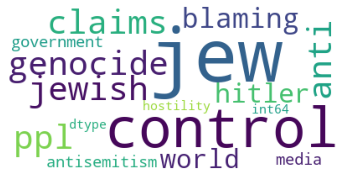

In [64]:
#Build a word cloud visualization

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(collocations = False, background_color = 'white').generate(str(desc_column_without_sw))

plt.imshow(wordcloud)
plt.axis("off")


plt.savefig("wordcloud.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

###### /\ The series dtype: int64 is being ploting        

In [95]:
#A full pdf report extraction

from matplotlib.backends.backend_pdf import PdfPages
from fpdf import FPDF

pdf = FPDF()

pdf.add_page()

pdf.set_font('Arial', size = 16)

pdf.cell(40)

pdf.cell(75, 10,'Inner report', 0, 2, 'C')

pdf.cell(80, 10, '', 0, 2, 'C')
pdf.cell(-17)

pdf.image("posts_in_platforms.png")

pdf.cell(90, 20, '', 0, 2, 'C')
pdf.cell(-3)

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(-3)


# pdf.image("sort_by_language.png")

# pdf.cell(90, 10, '', 0, 2, 'C')
# pdf.cell(10)

pdf.image("categories_per_each_platform.png")

pdf.cell(90, 20, '', 0, 2, 'C')
pdf.cell(7)

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(7)

pdf.image("general_removal_view_plot.png")

pdf.cell(90, 20, '', 0, 2, 'C')
pdf.cell(-2)

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(-2)

pdf.image("outpot_category_removal_stats_plot.png")

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(-7)

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(-7)

pdf.image("precentage_chart_plot.png")

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(4)

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(4)

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(4)


pdf.image("wordcloud.png")

pdf.output("Inner report.pdf")



''